# Instance Segmentation using Mask R-CNN
- object detection (Fatser RCNN) + image segmentation
- use a pretained model which has ResNet-50-FPN backbone

Mask R-CNN Image Segmentation Demo
- https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb#scrollTo=DL_0tSC67biu

## 1. Use a free Cloud TPU
- On the main menu, click Runtime and select Change runtime type. Set "TPU" as the hardware accelerator.
- Click Runtime again and select Runtime > Run All. You can also run the cells manually with Shift-ENTER.

## 2. Download the source code

In [ ]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10292, done.
remote: Counting objects: 100% (494/494), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 10292 (delta 260), reused 347 (delta 183), pack-reused 9798
Receiving objects: 100% (10292/10292), 24.51 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (7298/7298), done.


## 3. Import Libraries

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')   # search inserted path first
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

TensorFlow 1.x selected.


## 4. Load the COCO index mapping
- This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

In [ ]:
category_index

## 5. Load an image

--2021-11-09 07:47:07--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1445451 (1.4M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1.38M  8.70MB/s    in 0.2s    

2021-11-09 07:47:08 (8.70 MB/s) - ‘test.jpg’ saved [1445451/1445451]



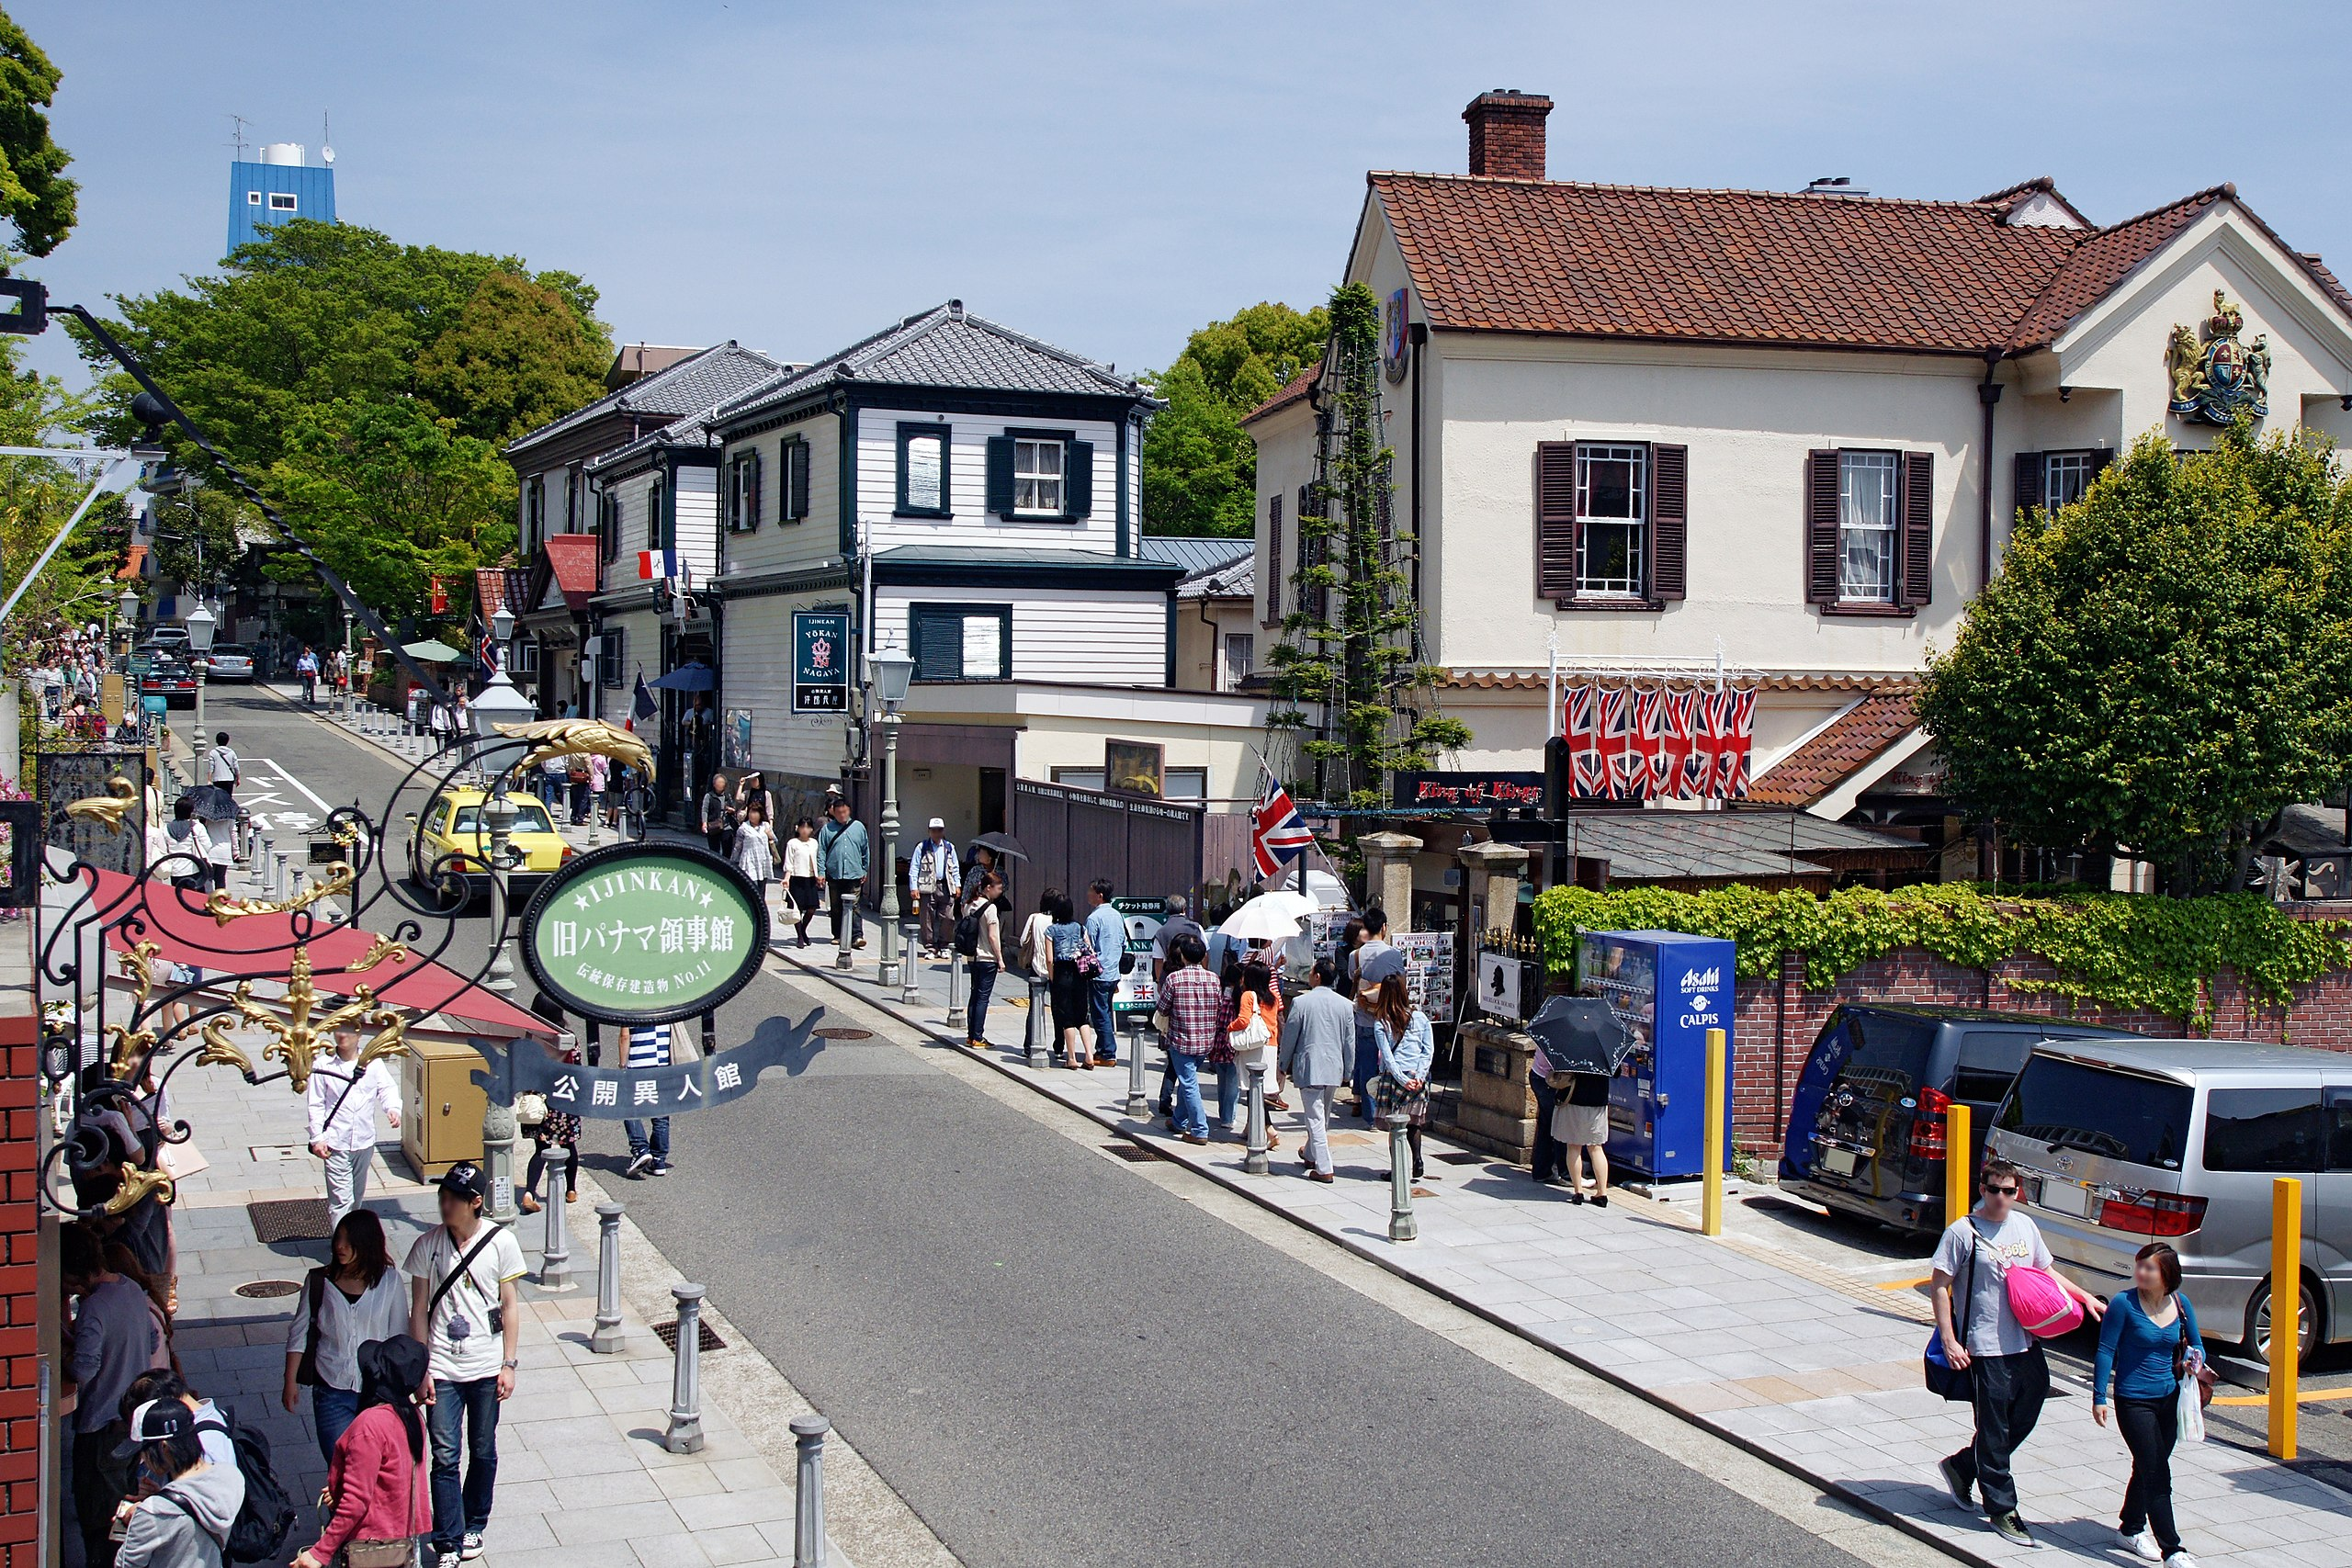

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## 6. Create a Tensorflow session
- Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [ ]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.33.197.138:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 10854385195593660283),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6634178906087118023),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6712241290851656917),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10011817238282389287),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 514036187671204258),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 14464628110322886117),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 15034034092953713917),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12385969407802656788),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 17861077862

## 7. Load the pretrained model
- Loading the COCO pretrained saved model from the public GCS bucket.

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## 8. Perform instance segmentation and retrieve the predictions
- Now let's run the inference and process the predictions from the model.

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

## 9. Visualize the detection results

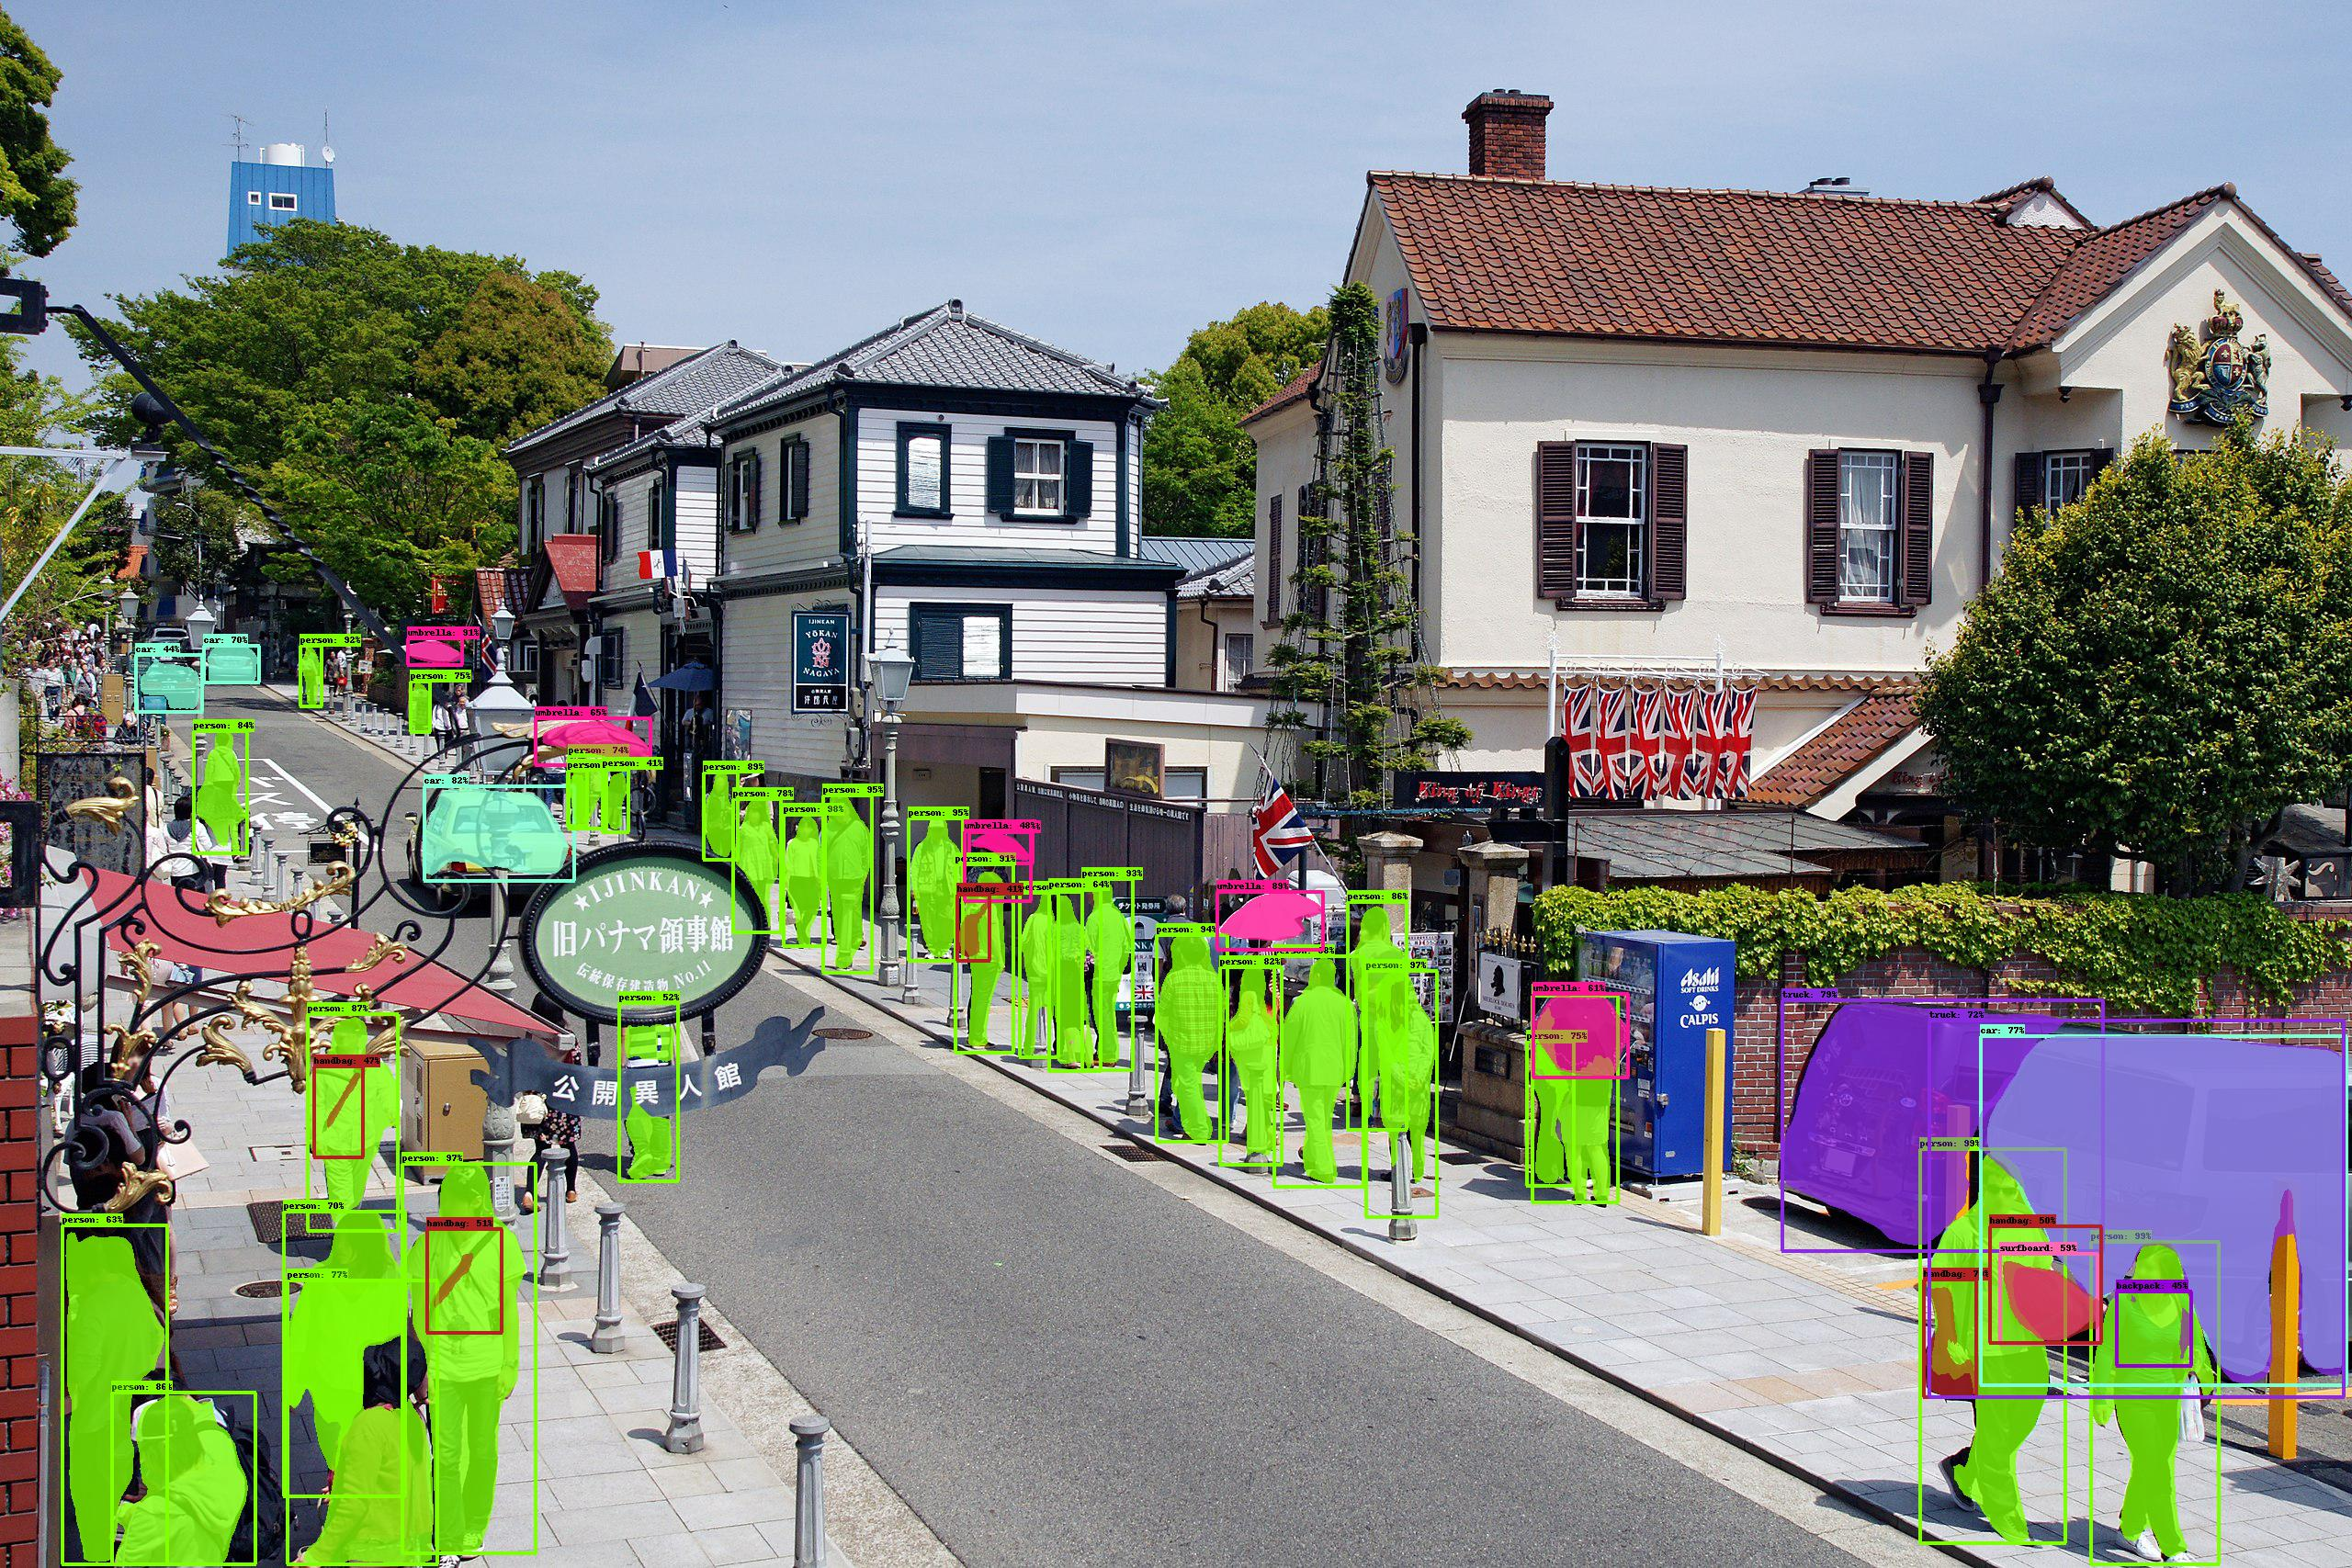

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.1    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# Detectron2 Mask R-CNN
- https://www.youtube.com/watch?v=sbcC6N5xfy8

# 설치
- Tutorial: https://detectron2.readthedocs.io/tutorials/install.html
- Detectron2: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

In [4]:
!pip install pyyaml==5.1
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
            

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu102/torch-1.9.0%2Bcu102-cp38-cp38-linux_x86_64.whl (831.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.1/22.1 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tor

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.0+cu116 True


# 사전 모델
input.jpg: http://images.cocodataset.org/val2017/000000439715.jpg

In [10]:
import os
from os.path import exists, join, basename, splitext

import sys
import time
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False

from IPython.display import clear_output

In [7]:
git_repo_url = 'https://github.com/facebookresearch/Detectron.git'
project_name = splitext(basename(git_repo_url))[0]
sys.path.append(project_name)

In [8]:
if not exists(project_name):
    !git clone -q --depth 1 $git_repo_url
    !cd $project_name && pip install -q -r requirements.txt
    !cd $project_name && make

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 3.12 which is incompatible.
python setup.py develop --user
Compiling detectron/utils/cython_bbox.pyx because it changed.
Compiling detectron/utils/cython_nms.pyx because it changed.
[1/2] Cythonizing detectron/utils/cython_bbox.pyx
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Detectron/detectron/utils/cython_bbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing detectron/utils/cython_nms.pyx
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: F

In [9]:
!python $project_name/detectron/tests/test_spatial_narrow_as_op.py

/usr/local/lib/python3.8/dist-packages/caffe2/__init__.py:5: UserWarning: Caffe2 support is not fully enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn("Caffe2 support is not fully enabled in this PyTorch build. "
/usr/local/lib/python3.8/dist-packages/caffe2/proto/__init__.py:17: UserWarning: Caffe2 support is not enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn('Caffe2 support is not enabled in this PyTorch build. '
Traceback (most recent call last):
  File "Detectron/detectron/tests/test_spatial_narrow_as_op.py", line 24, in <module>
    from caffe2.proto import caffe2_pb2
  File "/usr/local/lib/python3.8/dist-packages/caffe2/proto/__init__.py", line 15, in <module>
    from caffe2.proto import caffe2_pb2, metanet_pb2, torch_pb2
ImportError: cannot import name 'metanet_pb2' from partially initialized module 'caffe2.proto' (most 